In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import os
from datetime import datetime

In [24]:
data_directory = 'data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_merged.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]

In [25]:
# Read and modify batch_corrected_expression
batch_corrected_expression = pd.read_csv(f'{data_directory}{file_names[0]}')
batch_corrected_expression = batch_corrected_expression.rename(columns={batch_corrected_expression.columns[0]: "CellLineID"})
batch_corrected_expression.columns = ['CellLineID'] + [f"1_{col}" for col in batch_corrected_expression.columns[1:]]

# Read and modify damaging_mutations
damaging_mutations = pd.read_csv(f'{data_directory}{file_names[1]}')
damaging_mutations = damaging_mutations.rename(columns={damaging_mutations.columns[0]: "CellLineID"})
damaging_mutations.columns = ['CellLineID'] + [f"2_{col}" for col in damaging_mutations.columns[1:]]

# Read and modify harmonized_RPPA
harmonized_RPPA = pd.read_csv(f'{data_directory}{file_names[2]}')
harmonized_RPPA = harmonized_RPPA.rename(columns={harmonized_RPPA.columns[0]: "CellLineID"})
harmonized_RPPA.columns = ['CellLineID'] + [f"3_{col}" for col in harmonized_RPPA.columns[1:]]

# Read and modify hotspot_mutations
hotspot_mutations = pd.read_csv(f'{data_directory}{file_names[3]}')
hotspot_mutations = hotspot_mutations.rename(columns={hotspot_mutations.columns[0]: "CellLineID"})
hotspot_mutations.columns = ['CellLineID'] + [f"4_{col}" for col in hotspot_mutations.columns[1:]]

IC50_AUC = pd.read_csv(f'{data_directory}{file_names[4]}')
IC50_AUC = IC50_AUC.rename(columns={IC50_AUC.columns[0]: "CellLineID"})

# Read and modify metabolomics
metabolomics = pd.read_csv(f'{data_directory}{file_names[5]}')
metabolomics = metabolomics.rename(columns={metabolomics.columns[0]: "CellLineID"})
metabolomics.columns = ['CellLineID'] + [f"5_{col}" for col in metabolomics.columns[1:]]

# Read and modify miRNA_expression
miRNA_expression = pd.read_csv(f'{data_directory}{file_names[6]}')
miRNA_expression = miRNA_expression.rename(columns={miRNA_expression.columns[0]: "CellLineID"})
miRNA_expression.columns = ['CellLineID'] + [f"6_{col}" for col in miRNA_expression.columns[1:]]

# Read and modify absolute_copy_number
absolute_copy_number = pd.read_csv(f'{data_directory}{file_names[7]}')
absolute_copy_number = absolute_copy_number.rename(columns={absolute_copy_number.columns[0]: "CellLineID"})
absolute_copy_number = absolute_copy_number.drop(columns=["cell_line_display_name", "lineage_1", "lineage_2", "lineage_3", "lineage_6", "lineage_4"])
absolute_copy_number.columns = ['CellLineID'] + [f"7_{col}" for col in absolute_copy_number.columns[1:]]


C:\Users\user\AppData\Local\Temp\ipykernel_19736\2248293798.py:35: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  absolute_copy_number = pd.read_csv(f'{data_directory}{file_names[7]}')


In [26]:
batch_corrected_expression


,CellLineID,1_NEMP2,1_SPDYE11,1_MED6,1_SPATA1,1_HMG20B,1_PITRM1,1_TCIRG1,1_CDKN2B,1_MKRN2OS,...,1_XYLB,1_CDC25A,1_NR1H4,1_NUP153,1_SUPT7L,1_GFPT2,1_USP15,1_IQSEC1,1_FGFBP1,1_FGF19
0,ACH-000873,2.281262,0.016496,4.913394,0.592549,4.933815,5.068384,4.910413,0.996458,0.035011,...,1.522375,2.734131,0.036676,4.489500,4.126495,2.933520,4.679719,2.658149,6.949334,0.067254
1,ACH-000860,2.397921,-0.007359,6.064227,0.790612,5.526024,5.495815,5.223437,3.722068,0.486790,...,2.401933,4.026986,0.102299,4.812712,4.754488,1.668809,5.260394,2.678779,5.844726,0.406430
2,ACH-000439,1.961548,0.139871,4.366399,0.574739,5.879936,5.027458,6.596313,-0.026794,0.283322,...,1.871678,4.355534,-0.004244,4.359530,4.027693,0.044818,4.765310,3.460506,-0.096728,0.001493
3,ACH-000318,2.962951,-0.007359,6.028266,0.636129,4.722188,5.235858,5.235896,0.043358,2.200371,...,1.720886,2.895112,-0.004244,3.991084,4.657785,1.441628,5.563495,1.228177,7.678403,0.001493
4,ACH-001142,1.997125,-0.007359,4.781246,1.004993,5.559541,6.614231,6.000796,5.244141,-0.048123,...,1.816077,2.128269,0.050052,4.144621,4.822296,6.326762,5.743718,3.069706,-0.137807,-0.012049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668,ACH-001843,2.425672,0.016474,5.064429,1.155729,6.132326,6.435993,6.059272,0.075189,0.294127,...,1.809829,2.525644,0.004200,3.596841,5.268157,4.697931,5.741231,2.436233,0.248119,0.045752
1669,ACH-002074,2.435179,0.016474,4.795754,0.494388,5.265443,5.683454,1.697058,1.882359,0.230385,...,1.768574,4.710684,0.004200,6.343630,4.363348,1.019808,5.406873,4.043767,1.515018,0.091958
1670,ACH-001164,1.893673,0.016474,4.460321,0.362453,5.729537,7.230451,4.420567,1.809993,0.190636,...,1.584718,3.526075,0.019553,3.603731,3.929013,1.789794,4.072432,2.397131,0.590804,0.014186
1671,ACH-003180,2.717188,0.016474,4.991506,0.604765,5.400438,5.396326,4.389461,3.618080,0.190636,...,3.326611,3.303162,0.004200,4.711988,4.557213,3.643244,5.510186,3.488515,0.248119,0.014186


In [27]:
# IC50, AUC, SMILES combine
smiles = pd.read_csv("./data/drugID_name_pubchem_smiles.csv")
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)


In [28]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)

pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'value', 'Metric','DrugNumber']]

In [29]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None

In [30]:
final_IC50_AUC.to_csv("temp.csv")
IC50_AUC_final = pd.read_csv("temp.csv")
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')
ic50_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'IC50']].copy()
ic50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = ic50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
IC50_AUC_CLS = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

IC50_AUC_CLS = IC50_AUC_CLS.drop(columns=["DrugNumber", "smiles"])

C:\Users\user\AppData\Local\Temp\ipykernel_19736\4116585332.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


In [31]:
# apply scaling method which were used to train individual models

# expression: PCA
expression_cnv = batch_corrected_expression.iloc[:, 1:]
pca_expression = PCA(n_components=500)
expression_pca = pca_expression.fit_transform(expression_cnv)
expression_pca_df = pd.DataFrame(expression_pca)
expression_pca_df.insert(0, "CellLineID", batch_corrected_expression["CellLineID"].values)
expression_pca_df.columns = ['CellLineID'] + [f"1_{col}" for col in expression_pca_df.columns[1:]]
expression_pca_df

,CellLineID,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,1_490,1_491,1_492,1_493,1_494,1_495,1_496,1_497,1_498,1_499
0,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,-2.321504,-5.421651,-1.193897,1.788031,1.495077,1.610082,3.555438,-1.997517,-0.867173,-3.192286
1,ACH-000860,-13.205043,35.412796,18.626327,-18.780661,-3.658211,-18.184392,-9.531211,-6.630401,0.281756,...,1.350454,2.436782,-2.068340,-2.313506,1.658322,0.602375,1.434755,0.335589,0.082353,-0.558737
2,ACH-000439,105.578540,-7.727870,-54.957863,12.811952,-0.432278,10.199582,8.024432,48.359902,-5.190777,...,2.226108,-2.637741,2.006790,1.389950,1.592470,0.389373,1.252179,0.232699,-0.899853,5.219488
3,ACH-000318,-7.327347,53.451898,-7.430361,19.708346,-17.924429,-16.075850,-29.364873,-9.784038,-11.851439,...,1.409892,-0.233542,-0.559557,-1.014885,-2.071434,-2.666334,1.868028,-4.059991,3.258332,-0.916755
4,ACH-001142,-68.076659,-48.781471,-41.877034,-14.293056,-13.285048,10.213185,13.815636,-1.810762,-3.815925,...,-0.473048,2.011378,-1.611221,1.318724,-1.446495,-0.874178,0.247021,3.245773,2.598609,2.512914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668,ACH-001843,-17.993345,-23.106219,-11.477149,12.734862,10.910127,-2.627428,7.090688,10.285014,7.435539,...,-0.943412,6.859956,2.480149,-0.452424,-0.503193,-0.004739,-0.062963,-0.691090,0.613382,-4.103107
1669,ACH-002074,13.293219,-34.315645,124.754849,-4.390610,-27.125356,37.669803,-2.080660,-38.162244,9.140773,...,4.669366,-0.280697,0.362372,-5.373513,-1.182544,-1.003638,1.032190,2.484447,0.706047,-2.601931
1670,ACH-001164,7.325350,-23.149983,-20.506041,41.769200,-14.242126,21.603492,10.547421,29.343744,2.192337,...,-1.151335,0.336835,1.155761,-0.142555,-6.100099,-1.961802,1.080138,2.045843,-2.425254,-1.723153
1671,ACH-003180,-53.328758,-50.682140,-29.751308,-13.790538,-17.731040,16.326983,16.623389,-8.590972,-25.676557,...,0.792584,1.018562,0.184851,1.362704,2.801868,-1.326434,5.700682,3.146462,-2.676564,-0.628609


In [32]:
# damaging mutation: Variance threshold + rubust scaling
dmg_mut = damaging_mutations.drop(columns="CellLineID")
selector_mut = VarianceThreshold(threshold=0.01)
dmg_mut_reduced = selector_mut.fit_transform(dmg_mut)
selected_columns_mut = dmg_mut.columns[selector_mut.get_support()]
scaler_mut = RobustScaler()
dmg_mut_reduced = scaler_mut.fit_transform(dmg_mut_reduced) 
dmg_mut_reduced_df = pd.DataFrame(dmg_mut_reduced, columns=selected_columns_mut)
dmg_mut_reduced_df = pd.concat([damaging_mutations["CellLineID"], dmg_mut_reduced_df], axis=1)
dmg_mut_reduced_df

,CellLineID,2_A2ML1,2_ABCA10,2_ABCA12,2_ABCA13,2_ABCA2,2_ABCA4,2_ABCA5,2_ABCA6,2_ABCA8,...,2_ZNF711,2_ZNF729,2_ZNF750,2_ZNF804B,2_ZNF831,2_ZNF90,2_ZNF99,2_ZRANB3,2_ZSWIM6,2_ZZEF1
0,ACH-000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACH-000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACH-000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACH-000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ACH-000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1925,ACH-003474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1926,ACH-003475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,ACH-003476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# protein: standard scaler
prot = harmonized_RPPA.drop(columns="CellLineID")
scaler_protein = StandardScaler()
protein_scaled = scaler_protein.fit_transform(prot)
protein_scaled_df = pd.DataFrame(protein_scaled)
protein_scaled_df.insert(0, "CellLineID", harmonized_RPPA["CellLineID"].values)
protein_scaled_df.columns = ['CellLineID'] + [f"3_{col}" for col in protein_scaled_df.columns[1:]]
protein_scaled_df

,CellLineID,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,...,3_134,3_135,3_136,3_137,3_138,3_139,3_140,3_141,3_142,3_143
0,ACH-000698,-0.612917,0.223323,0.606426,0.721333,0.110235,0.179933,-0.114938,-0.940047,-0.957034,...,-1.062067,2.484835,-0.517883,-1.016179,1.475021,-0.654903,-0.819080,-0.021027,-0.314445,-0.504282
1,ACH-000489,1.649916,-1.009740,-0.200529,0.038992,1.579026,-0.893064,-0.443334,-0.060601,0.154512,...,1.980290,6.054042,0.067953,0.662172,1.235912,-0.275541,0.767357,0.444319,-0.646511,-0.023882
2,ACH-000431,0.039605,0.282172,-0.324024,0.340225,-0.044571,0.972972,-0.527327,-0.154960,0.964029,...,-1.185110,-0.428942,-0.700518,2.254630,-0.697849,-0.651034,-0.850240,0.602303,-0.906461,1.634607
3,ACH-000707,0.485446,-0.428368,-0.400411,-0.041245,-1.136608,0.183832,-1.495605,0.244413,-0.756761,...,-1.331765,-0.183950,-0.809336,-0.026228,0.948358,2.253929,-3.090354,-1.461826,2.234051,0.081316
4,ACH-000509,-1.414293,-0.394963,-0.423156,-0.781748,-0.612832,-0.349126,0.679537,-1.288470,0.694292,...,0.936852,-0.168559,-0.738633,-0.710741,-0.760559,2.050669,-0.334478,-0.368402,-0.982283,1.228356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,ACH-000428,0.110377,0.391061,0.137401,-0.395569,-0.221911,1.067014,0.336480,-0.960471,0.388553,...,-0.300115,0.262923,0.710310,0.230650,-0.365990,-0.371611,0.641735,-0.390669,0.906651,-0.327067
895,ACH-000655,-0.269672,0.251754,-0.863469,-0.349136,-1.260717,-0.185840,-0.195436,-0.649806,-0.837895,...,-1.029560,-0.317276,-0.255798,-0.686808,-0.209949,-0.458913,-0.094344,-1.043973,-1.472114,-0.579963
896,ACH-000273,-1.326400,2.067889,-0.875423,0.569805,0.003275,-0.113267,0.732226,-0.177328,1.495660,...,-0.670747,-1.012161,-0.585764,-0.377737,-0.285001,-0.276757,-0.173452,-1.107292,0.207267,0.561858
897,ACH-000504,-0.783560,0.911902,-0.418151,-0.612986,-0.056590,-0.310806,0.402894,-0.442600,0.504737,...,-1.541053,-0.800185,-0.505402,0.393043,-0.357944,-0.497675,0.491758,-0.902171,-1.446228,-0.568729


In [34]:
# hotspot mutation: standard scaler
hot_mut = hotspot_mutations.drop(columns="CellLineID")
scaler_hotspot = StandardScaler()
hotspot_scaled = scaler_hotspot.fit_transform(hot_mut)
hotspot_scaled_df = pd.DataFrame(hotspot_scaled)
hotspot_scaled_df.insert(0, "CellLineID", hotspot_mutations["CellLineID"].values)
hotspot_scaled_df.columns = ['CellLineID'] + [f"4_{col}" for col in hotspot_scaled_df.columns[1:]]
hotspot_scaled_df

,CellLineID,4_0,4_1,4_2,4_3,4_4,4_5,4_6,4_7,4_8,...,4_529,4_530,4_531,4_532,4_533,4_534,4_535,4_536,4_537,4_538
0,ACH-000001,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1,ACH-000002,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
2,ACH-000004,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
3,ACH-000005,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
4,ACH-000006,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1925,ACH-003474,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1926,ACH-003475,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1927,ACH-003476,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774


In [35]:
# metabolomics: standard scaler
meta = metabolomics.drop(columns="CellLineID")
scaler_metabolomics = StandardScaler()
metabolomics_scaled = scaler_metabolomics.fit_transform(meta)
metabolomics_scaled_df = pd.DataFrame(metabolomics_scaled)
metabolomics_scaled_df.insert(0, "CellLineID", metabolomics["CellLineID"].values)
metabolomics_scaled_df.columns = ['CellLineID'] + [f"5_{col}" for col in metabolomics_scaled_df.columns[1:]]
metabolomics_scaled_df

,CellLineID,5_0,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,...,5_215,5_216,5_217,5_218,5_219,5_220,5_221,5_222,5_223,5_224
0,ACH-000698,0.557284,0.515189,-0.054878,0.135187,-1.043681,-0.129531,0.414312,-0.638396,-0.129797,...,0.513798,0.426691,0.353608,0.708122,1.060755,0.750534,-0.028667,0.681854,0.339773,0.172341
1,ACH-000489,-1.153386,-0.455615,-1.561702,0.352185,-0.099291,-0.252544,-0.036573,-0.363507,-0.471001,...,1.023767,1.569556,1.036571,0.879770,1.033590,1.087359,0.433064,2.113894,1.574201,0.873145
2,ACH-000431,-0.165981,-0.936554,-0.737158,-0.318869,-0.548701,-0.109933,-0.005529,-0.103380,-0.509048,...,0.149783,0.000650,-0.248786,-0.001200,0.518728,-0.264772,-0.578523,-0.130029,-0.230330,-0.782058
3,ACH-000707,-0.537852,0.720730,0.590426,-1.228664,-0.212848,0.672876,1.097971,0.297578,0.747467,...,1.790577,0.381808,0.808239,0.689492,0.454086,0.341955,-0.245347,0.908357,-0.239624,0.638919
4,ACH-000509,-1.462500,-1.268864,1.120189,0.882626,-2.099762,-0.049797,1.287728,-0.950836,-0.238966,...,0.776029,1.899423,1.746608,1.610213,1.932546,1.219787,1.706747,1.530576,1.395632,1.867989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,ACH-000655,0.125581,0.490805,1.064821,0.467987,0.148612,-0.509327,0.434753,2.158001,-0.717929,...,-0.979465,-0.554915,-0.858667,-0.838440,-1.267921,-1.512691,-0.924243,-0.767200,-1.760266,-0.776712
923,ACH-000273,0.060382,0.694197,-1.154972,0.568667,-0.299668,-0.864138,1.470717,0.497303,-0.673935,...,-0.506716,-0.674703,-0.527957,-1.083407,-1.467146,-1.595997,-1.068780,-0.788050,-1.343282,-0.881662
924,ACH-000504,0.093852,0.190556,-0.585055,0.000092,0.334694,-1.480546,0.305665,1.356817,-0.959219,...,-0.814866,-1.437779,-0.743024,-0.989967,-1.340031,-1.103159,-0.890545,-1.521454,-1.565363,-1.533381
925,ACH-000825,0.076940,0.383840,0.711219,-0.115915,0.690186,-0.086400,0.299768,1.142896,-0.344986,...,0.169536,0.691391,0.728826,0.445061,-0.090201,-0.217227,0.107072,0.873816,0.321537,0.919807


In [36]:
# miRNA: standard scaler
rna = miRNA_expression.drop(columns="CellLineID")
scaler_miRNA = StandardScaler()
miRNA_scaled = scaler_miRNA.fit_transform(rna)
miRNA_scaled_df = pd.DataFrame(miRNA_scaled)
miRNA_scaled_df.insert(0, "CellLineID", miRNA_expression["CellLineID"].values)
miRNA_scaled_df.columns = ['CellLineID'] + [f"6_{col}" for col in miRNA_scaled_df.columns[1:]]

In [37]:
# copy number: PCA
CN_cnv = absolute_copy_number.iloc[:, 1:]
pca_CN = PCA(n_components=500)
CN_pca = pca_CN.fit_transform(CN_cnv)
CN_pca_df = pd.DataFrame(CN_pca)
CN_pca_df.insert(0, "CellLineID", absolute_copy_number["CellLineID"].values)
CN_pca_df.columns = ['CellLineID'] + [f"7_{col}" for col in CN_pca_df.columns[1:]]

In [38]:
# AUC: log transform
epsilon = 1e-10  # prevent zero division
y = IC50_AUC_CLS[["AUC", "IC50"]]
y_array = y.to_numpy(dtype=np.float32)
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))

In [39]:
# IC50: minmax scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [40]:
IC50_AUC_CLS["AUC"] = y_array[:, 0]
IC50_AUC_CLS["IC50"] = y_array[:, 1]

In [41]:
# save each data's feature name, and merge everything
expression_n = expression_pca_df.columns.tolist()
dmg_mut_n = dmg_mut_reduced_df.columns.tolist()
protein_n = protein_scaled_df.columns.tolist()
hot_mut_n = hotspot_scaled_df.columns.tolist()
meta_n = metabolomics_scaled_df.columns.tolist()
RNA_n = miRNA_scaled_df.columns.tolist()
CN_n = CN_pca_df.columns.tolist()
IC50_AUC_CLS_n = IC50_AUC_CLS.columns.tolist()

all_data = dmg_mut_reduced_df.merge(expression_pca_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(protein_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(hotspot_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(metabolomics_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(miRNA_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(CN_pca_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(IC50_AUC_CLS, on='CellLineID', how = 'inner')

all_data.shape

(59303, 3900)

In [45]:
# re-separate 
expression = all_data[expression_n[1:]]
damaging_mutation = all_data[dmg_mut_n[1:]]
protein = all_data[protein_n[1:]]
hotspot_mutation = all_data[hot_mut_n[1:]]
metabolomic = all_data[meta_n[1:]]
miRNA = all_data[RNA_n[1:]]
copy_number = all_data[CN_n[1:]]
target = all_data[["AUC", "IC50"]]
cls = all_data["CLS"]

# convert to tensor
expression_tensor = torch.tensor(expression.to_numpy(dtype=np.float32))
damaging_mutation_tensor = torch.tensor(damaging_mutation.to_numpy(dtype=np.float32))
protein_tensor = torch.tensor(protein.to_numpy(dtype=np.float32))
hotspot_mutation_tensor = torch.tensor(hotspot_mutation.to_numpy(dtype=np.float32))
metabolomic_tensor = torch.tensor(metabolomic.to_numpy(dtype=np.float32))
miRNA_tensor = torch.tensor(miRNA.to_numpy(dtype=np.float32))
copy_number_tensor = torch.tensor(copy_number.to_numpy(dtype=np.float32))
target_tensor = torch.tensor(target.to_numpy(dtype=np.float32))
cls_tensor = torch.tensor(cls)

# train, validation, test split
train_smiles, test_smiles, train_expression, test_expression, train_damaging_mutation, test_damaging_mutation, train_protein, test_protein, train_hotspot_mutation, test_hotspot_mutation, train_metabolomic, test_metabolomic, train_miRNA, test_miRNA, train_copy_number, test_copy_number, train_y, test_y = train_test_split(
    cls_tensor, expression_tensor, damaging_mutation_tensor, protein_tensor, hotspot_mutation_tensor, metabolomic_tensor, miRNA_tensor, copy_number_tensor, target_tensor, test_size=0.1, random_state=42)

train_smiles, val_smiles, train_expression, val_expression, train_damaging_mutation, val_damaging_mutation, train_protein, val_protein, train_hotspot_mutation, val_hotspot_mutation, train_metabolomic, val_metabolomic, train_miRNA, val_miRNA, train_copy_number, val_copy_number, train_y, val_y = train_test_split(
    train_smiles, train_expression, train_damaging_mutation, train_protein, train_hotspot_mutation, train_metabolomic, train_miRNA, train_copy_number, train_y, test_size=0.1, random_state=42)

print("train_smiles shape =", train_smiles.shape)
print("val_smiles shape =", val_smiles.shape)
print("test_smiles shape =", test_smiles.shape)
print("train_expression shape =", train_expression.shape)
print("val_expression shape =", val_expression.shape)
print("test_expression shape =", test_expression.shape)
print("train_damaging_mutation shape =", train_damaging_mutation.shape)
print("val_damaging_mutation shape =", val_damaging_mutation.shape)
print("test_damaging_mutation shape =", test_damaging_mutation.shape)
print("train_protein shape =", train_protein.shape)
print("val_protein shape =", val_protein.shape)
print("test_protein shape =", test_protein.shape)
print("train_hotspot_mutation shape =", train_hotspot_mutation.shape)
print("val_hotspot_mutation shape =", val_hotspot_mutation.shape)
print("test_hotspot_mutation shape =", test_hotspot_mutation.shape)
print("train_metabolomic shape =", train_metabolomic.shape)
print("val_metabolomic shape =", val_metabolomic.shape)
print("test_metabolomic shape =", test_metabolomic.shape)
print("train_miRNA shape =", train_miRNA.shape)
print("val_miRNA shape =", val_miRNA.shape)
print("test_miRNA shape =", test_miRNA.shape)
print("train_copy_number shape =", train_copy_number.shape)
print("val_copy_number shape =", val_copy_number.shape)
print("test_copy_number shape =", test_copy_number.shape)
print("train_y shape =", train_y.shape)
print("val_y shape =", val_y.shape)
print("test_y shape =", test_y.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_19736\1659156920.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  cls_tensor = torch.tensor(cls)


train_smiles shape = torch.Size([48034, 768])
val_smiles shape = torch.Size([5338, 768])
test_smiles shape = torch.Size([5931, 768])
train_expression shape = torch.Size([48034, 500])
val_expression shape = torch.Size([5338, 500])
test_expression shape = torch.Size([5931, 500])
train_damaging_mutation shape = torch.Size([48034, 1254])
val_damaging_mutation shape = torch.Size([5338, 1254])
test_damaging_mutation shape = torch.Size([5931, 1254])
train_protein shape = torch.Size([48034, 144])
val_protein shape = torch.Size([5338, 144])
test_protein shape = torch.Size([5931, 144])
train_hotspot_mutation shape = torch.Size([48034, 539])
val_hotspot_mutation shape = torch.Size([5338, 539])
test_hotspot_mutation shape = torch.Size([5931, 539])
train_metabolomic shape = torch.Size([48034, 225])
val_metabolomic shape = torch.Size([5338, 225])
test_metabolomic shape = torch.Size([5931, 225])
train_miRNA shape = torch.Size([48034, 734])
val_miRNA shape = torch.Size([5338, 734])
test_miRNA shape = 

In [46]:
train_dataset = TensorDataset(train_smiles, train_expression, train_damaging_mutation, train_protein, train_hotspot_mutation, train_metabolomic, train_miRNA, train_copy_number, train_y)
val_dataset = TensorDataset(val_smiles, val_expression, val_damaging_mutation, val_protein, val_hotspot_mutation, val_metabolomic, val_miRNA, val_copy_number, val_y)
test_dataset = TensorDataset(test_smiles, test_expression, test_damaging_mutation, test_protein, test_hotspot_mutation, test_metabolomic, test_miRNA, test_copy_number, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Train Dataset: 48034 samples
Validation Dataset: 5338 samples
Test Dataset: 5931 samples


# Model design

In [47]:
# individual model
##### !!!! should separate in other file, or just save the model itself (not only weight)
class MultiTaskRegressionTransformer(nn.Module):
    def __init__(self, chemberta_dim, d_model, nhead, num_layers, num_omics):
        super(MultiTaskRegressionTransformer, self).__init__()
        
        # CLS expression for SMILES is already embedded seperately by ChemBERTa
        self.chemberta_dim = chemberta_dim

        # Omics -> Transformer Encoder
        self.omics_fc = nn.Linear(num_omics, d_model)
        self.omics_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.omics_transformer = nn.TransformerEncoder(self.omics_encoder_layer, num_layers=num_layers)
        
        # cls -> embed to d_model dimension
        self.cls_proj = nn.Linear(self.chemberta_dim, d_model)
        
        # Cross-Attention (omics and drug data were embedded by different encoder, so we need to train their relationship additionally)
        # SMILES -> omics
        self.cross_attn_smiles = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        # Omics -> SMILES
        self.cross_attn_omics = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        
        # fuse two cross-attn information
        self.fusion_mlp = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        
        # prediction heads
        self.ic50_head = nn.Linear(d_model, 1)
        self.auc_head = nn.Linear(d_model, 1)
        
    def forward(self, cls_data, omics_data):
        """
        cls_data: SMILES CLS expression (batch_size, chemberta_dim)
        omics_data: (batch_size, num_omics) 
        """
        
        # Omics: fc → Transformer Encoder
        omics_repr = self.omics_fc(omics_data) # (batch_size, d_model)
        omics_repr = omics_repr.unsqueeze(1) # (batch_size, 1, d_model)
        omics_repr = self.omics_transformer(omics_repr) # (batch_size, 1, d_model)
        omics_repr = omics_repr.squeeze(1) # (batch_size, d_model)
        
        # project SMILES to d_model
        smiles_proj = self.cls_proj(cls_data) # (batch_size, d_model)
        
        # (batch_first=True → [batch, seq_len, d_model])
        smiles_seq = smiles_proj.unsqueeze(1) # (batch_size, 1, d_model)
        omics_seq = omics_repr.unsqueeze(1) # (batch_size, 1, d_model)
        
        # Cross-Attention
        # 1. SMILES -> omics: query=smiles, key/value=omics
        attn_smiles, _ = self.cross_attn_smiles(query=smiles_seq, key=omics_seq, value=omics_seq)
        # 2. Omics -> SMILES: query=omics, key/value=smiles
        attn_omics, _ = self.cross_attn_omics(query=omics_seq, key=smiles_seq, value=smiles_seq)
        
        # Residual connection (add attention result to original data) -> reserve original data
        smiles_updated = smiles_proj + attn_smiles.squeeze(1) # (batch_size, d_model)
        omics_updated = omics_repr + attn_omics.squeeze(1) # (batch_size, d_model)
        
        # Send to MLP
        fused = torch.cat([smiles_updated, omics_updated], dim=1) # (batch_size, 2*d_model)
        fused = self.fusion_mlp(fused) # (batch_size, d_model)
        
        # Final prediction
        ic50_pred = self.ic50_head(fused) # (batch_size, 1)
        auc_pred = self.auc_head(fused) # (batch_size, 1)
        
        return ic50_pred, auc_pred

In [ ]:
# 모델 클래스 정의 (저장할 때 사용한 클래스와 동일해야 함)
#model = MultiTaskRegressionTransformer()  # YourModelClass()는 저장한 모델의 클래스

# 모델 가중치 불러오기
#model.load_state_dict(torch.load("model.pth"))

# 모델을 평가 모드로 전환 (추론 시 필요)
#model.eval()


In [48]:
# check name of models
"""
order: expression, damaging_mutation, protein_tensor, hotspot_mutation,
metabolomic_tensor, miRNA, copy_number

should keep the order in final_models folder!
"""
folder_path = './final_models'  # 폴더 경로 지정
model_names = os.listdir(folder_path)

print(model_names)

['1_best_model_Expression_20250310_105831.pth', '2_best_model_Damaging_Mutations_20250310_042734.pth', '3_best_model_protein_20250310_065556.pth', '4_best_model_Hotspot_Mutations_20250310_014321.pth', '5_best_model_metabolomics_20250309_181849.pth', '6_best_model_miRNA_20250309_111221.pth', '7_best_model_CN_20250310_080710.pth']


In [51]:
d_model = 512 # can be adjust, should be divisible by nhead
nhead = 8 # can be adjust
num_layers = 4 # can be adjust
cls_dim = train_smiles.shape[1]
omics_dimension_list = [train_expression.shape[1], train_damaging_mutation.shape[1], train_protein.shape[1], train_hotspot_mutation.shape[1], train_metabolomic.shape[1], train_miRNA.shape[1], train_copy_number.shape[1]]


In [75]:
class FinalModel(nn.Module):
    def __init__(self, model_paths):
        """
        drug_input_dim: drug structure의 feature dimension (예: 100)
        omics_dims: 각 omics 데이터의 feature dimension (예시)
        """
        super(FinalModel, self).__init__()
        
        # call pretrained models, and freeze
        self.pretrained_models = nn.ModuleList()
        for i in range(7):
            model = MultiTaskRegressionTransformer(cls_dim, d_model, nhead, num_layers, omics_dimension_list[i])
            model_path = './final_models/' + model_paths[i]
            model.load_state_dict(torch.load(model_path))
    
            for param in model.parameters():
                param.requires_grad = False
            self.pretrained_models.append(model)
        
        self.fc1 = nn.Linear(14, 64) # 2 * 7
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2) 

    def forward(self, drug_input, omics_inputs):
        """
        drug_input: Tensor, shape (batch_size, drug_input_dim)
        omics_inputs: list of 7 Tensors
        """
        ic50_preds = []
        auc_preds = []

        # 7개의 모델에 각각 데이터 전달 -> (batch_size,)씩 나옴
        for i, model in enumerate(self.pretrained_models):
            ic50_pred, auc_pred = model(drug_input, omics_inputs[i]) # (batch_size,), (batch_size,)
            
            # 반드시 unsqueeze(1)을 사용해 (batch_size,) -> (batch_size, 1)로 변환
            ic50_preds.append(ic50_pred.unsqueeze(1))
            auc_preds.append(auc_pred.unsqueeze(1))
            #print(ic50_preds.shape)

        # (batch_size, 7)씩 나눠서 concat
        ic50_preds = torch.cat(ic50_preds, dim=1) # (batch_size, 7)
        auc_preds = torch.cat(auc_preds, dim=1)   # (batch_size, 7)
        #print(ic50_preds.shape)

        # 두 개의 예측값을 합쳐서 (batch_size, 14)로 변환
        concat_preds = torch.cat([ic50_preds, auc_preds], dim=1) # (batch_size, 14)
        concat_preds = concat_preds.squeeze(2)
        #print(concat_preds.shape)
        
        # 최종 MLP를 거쳐서 최종 IC50/AUC 예측
        x = F.relu(self.fc1(concat_preds))
        x = F.relu(self.fc2(x))
        output = self.fc3(x) # (batch_size, 2)

        return output[:, 0], output[:, 1] # (batch_size,), (batch_size,)





In [76]:
model = FinalModel(model_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [79]:
num_epochs = 1000
patience = 100 # for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None

# training loop
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0
    for batch in train_loader:
        smiles_list, expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data, targets = batch
        omics_data = [expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data]
        ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
        
        smiles_list = smiles_list.to(device)
        omics_data = [data.to(device) for data in omics_data]
        ic50_targets = ic50_targets.to(device)
        auc_targets = auc_targets.to(device)
        
        optimizer.zero_grad()
        ic50_pred, auc_pred = model(smiles_list, omics_data)

        # weight for auc loss and IC50 loss
        w_ic50 = 2.0 # AUC is trained easier than IC50, so set IC50 weight larger (need further experiment)
        w_auc = 1.0   
        loss = 0.0
        
        # compute loss for valid target (which is not NAN)
        ic50_mask = ~torch.isnan(ic50_targets)
        auc_mask = ~torch.isnan(auc_targets)
        
        if ic50_mask.sum() > 0:
            loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask])
            loss += w_ic50 * loss_ic50
        if auc_mask.sum() > 0:
            loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask])
            loss += w_auc * loss_auc
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            smiles_list, expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data, targets = batch
            omics_data = [expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data]
            ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
            
            smiles_list = smiles_list.to(device)
            omics_data = [data.to(device) for data in omics_data]
            ic50_targets = ic50_targets.to(device)
            auc_targets = auc_targets.to(device)
            
            ic50_pred, auc_pred = model(smiles_list, omics_data)
            
            loss = 0.0
            ic50_mask = ~torch.isnan(ic50_targets)
            auc_mask = ~torch.isnan(auc_targets)
            
            if ic50_mask.sum() > 0:
                loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask])
                loss += loss_ic50
            if auc_mask.sum() > 0:
                loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask])
                loss += loss_auc
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")
    
    # best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"./best_models/best_final_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Epoch 1/1000 - Train Loss: 0.0113 - Validation Loss: 0.0024
Validation loss improved. Best model updated.
Epoch 2/1000 - Train Loss: 0.0026 - Validation Loss: 0.0014
Validation loss improved. Best model updated.
Epoch 3/1000 - Train Loss: 0.0020 - Validation Loss: 0.0012
Validation loss improved. Best model updated.
Epoch 4/1000 - Train Loss: 0.0018 - Validation Loss: 0.0011
Validation loss improved. Best model updated.
Epoch 5/1000 - Train Loss: 0.0017 - Validation Loss: 0.0011
Validation loss improved. Best model updated.
Epoch 6/1000 - Train Loss: 0.0017 - Validation Loss: 0.0011
Validation loss improved. Best model updated.
Epoch 7/1000 - Train Loss: 0.0016 - Validation Loss: 0.0011
No improvement for 1 epoch(s).
Epoch 8/1000 - Train Loss: 0.0016 - Validation Loss: 0.0010
Validation loss improved. Best model updated.
Epoch 9/1000 - Train Loss: 0.0015 - Validation Loss: 0.0010
Validation loss improved. Best model updated.
Epoch 10/1000 - Train Loss: 0.0015 - Validation Loss: 0.0010



 **Test Results:**
IC50_MSE: 0.0007
IC50_MAE: 0.0120
IC50_R2: 0.9734
AUC_MSE: 0.0004
AUC_MAE: 0.0143
AUC_R2: 0.9889


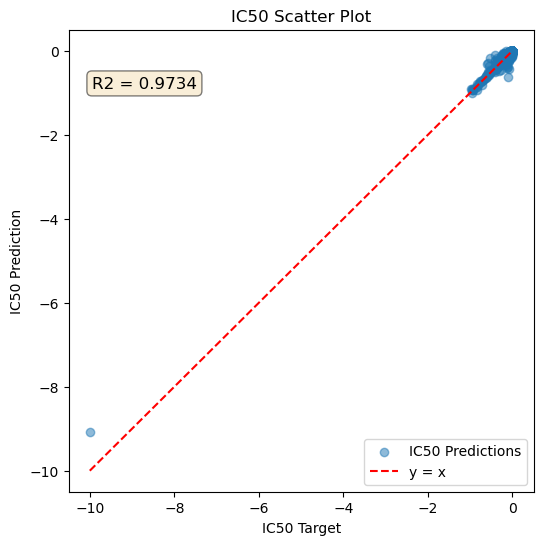

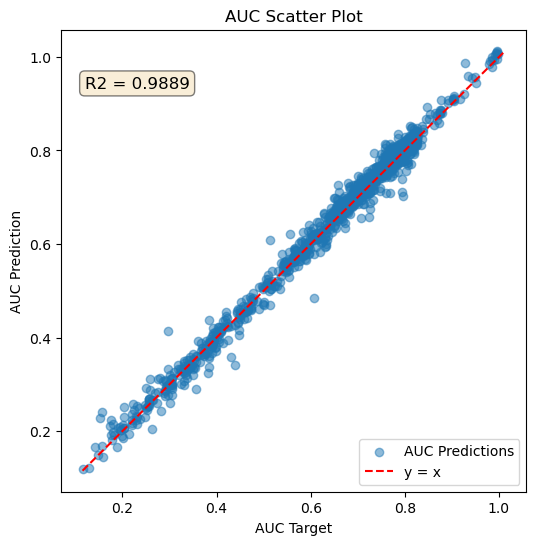

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# utility function for testing
def test_model(model, test_loader, device):
    model.eval()
    ic50_preds, ic50_targets = [], []
    auc_preds, auc_targets = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            smiles_list, expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data, targets = batch
            omics_data = [expression_data, damaging_mutation_data, protein_data, hotspot_mutation_data, metabolomic_data, miRNA_data, copy_number_data]
            ic50_true, auc_true = targets[:, 0], targets[:, 1]
            
            smiles_list = smiles_list.to(device)
            omics_data = [data.to(device) for data in omics_data]
            ic50_true = ic50_true.to(device)
            auc_true = auc_true.to(device)

            ic50_pred, auc_pred = model(smiles_list, omics_data)

            ic50_mask = ~torch.isnan(ic50_true)
            auc_mask = ~torch.isnan(auc_true)

            if ic50_mask.sum() > 0:
                ic50_preds.append(ic50_pred[ic50_mask].cpu().numpy())
                ic50_targets.append(ic50_true[ic50_mask].cpu().numpy())
            if auc_mask.sum() > 0:
                auc_preds.append(auc_pred[auc_mask].cpu().numpy())
                auc_targets.append(auc_true[auc_mask].cpu().numpy())

        # list -> numpy
        ic50_preds = np.concatenate(ic50_preds) if ic50_preds else np.array([])
        ic50_targets = np.concatenate(ic50_targets) if ic50_targets else np.array([])
        auc_preds = np.concatenate(auc_preds) if auc_preds else np.array([])
        auc_targets = np.concatenate(auc_targets) if auc_targets else np.array([])

        # evaluation
        metrics = {}
        if len(ic50_preds) > 0:
            metrics["IC50_MSE"] = mean_squared_error(ic50_targets, ic50_preds)
            metrics["IC50_MAE"] = mean_absolute_error(ic50_targets, ic50_preds)
            metrics["IC50_R2"] = r2_score(ic50_targets, ic50_preds)
        if len(auc_preds) > 0:
            metrics["AUC_MSE"] = mean_squared_error(auc_targets, auc_preds)
            metrics["AUC_MAE"] = mean_absolute_error(auc_targets, auc_preds)
            metrics["AUC_R2"] = r2_score(auc_targets, auc_preds)

        print("\n **Test Results:**")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
        
        # IC50 Scatter Plot
        if len(ic50_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(ic50_targets, ic50_preds, alpha=0.5, label="IC50 Predictions")
            # y = x 
            min_val = min(np.min(ic50_targets), np.min(ic50_preds))
            max_val = max(np.max(ic50_targets), np.max(ic50_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("IC50 Target")
            plt.ylabel("IC50 Prediction")
            plt.title("IC50 Scatter Plot")
            # R2
            plt.text(0.05, 0.90, f"R2 = {metrics['IC50_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        # AUC Scatter Plot
        if len(auc_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(auc_targets, auc_preds, alpha=0.5, label="AUC Predictions")
            min_val = min(np.min(auc_targets), np.min(auc_preds))
            max_val = max(np.max(auc_targets), np.max(auc_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("AUC Target")
            plt.ylabel("AUC Prediction")
            plt.title("AUC Scatter Plot")
            plt.text(0.05, 0.90, f"R2 = {metrics['AUC_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        return metrics

# load the best model
model.load_state_dict(torch.load(best_model_filename, map_location=device))

# test
test_metrics = test_model(model, test_loader, device)
